In [ ]:
# Image Folder
# Scheduler
# Transfer Learning

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import models, transforms, datasets
import matplotlib.pyplot as plt
import time
import os
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [3]:
#import data
data_dir = './hymenoptera_data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(class_names)
print(dataset_sizes)


['ants', 'bees']
{'train': 244, 'val': 153}


In [4]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


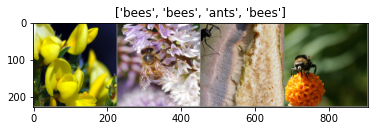

In [5]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
####
model =  models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs,2)
model.to(device)

creterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# scheduler 
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma= 0.1)

model = train_model(model, creterion, optimizer, step_lr_scheduler, num_epochs = 20)

Epoch 0/19
----------
train Loss: 0.7468 Acc: 0.5123
val Loss: 0.6165 Acc: 0.6601

Epoch 1/19
----------
train Loss: 0.6182 Acc: 0.6516
val Loss: 0.4730 Acc: 0.7974

Epoch 2/19
----------
train Loss: 0.5826 Acc: 0.7008
val Loss: 0.3768 Acc: 0.8562

Epoch 3/19
----------
train Loss: 0.4749 Acc: 0.8197
val Loss: 0.3636 Acc: 0.8758

Epoch 4/19
----------
train Loss: 0.4694 Acc: 0.7705
val Loss: 0.3053 Acc: 0.9150

Epoch 5/19
----------
train Loss: 0.4383 Acc: 0.8074
val Loss: 0.2800 Acc: 0.9216

Epoch 6/19
----------
train Loss: 0.4464 Acc: 0.8033
val Loss: 0.2737 Acc: 0.9085

Epoch 7/19
----------
train Loss: 0.4569 Acc: 0.7869
val Loss: 0.2545 Acc: 0.9346

Epoch 8/19
----------
train Loss: 0.4036 Acc: 0.8074
val Loss: 0.2537 Acc: 0.9346

Epoch 9/19
----------
train Loss: 0.3955 Acc: 0.8484
val Loss: 0.2489 Acc: 0.9281

Epoch 10/19
----------
train Loss: 0.4166 Acc: 0.8238
val Loss: 0.2474 Acc: 0.9346

Epoch 11/19
----------
train Loss: 0.3513 Acc: 0.8852
val Loss: 0.2495 Acc: 0.9346

Ep